In [1]:
from commons import auto_invert_image_mask, binarize_image, find_bighest_cluster, plot, find_bighest_cluster_area
from skimage.transform import resize
from skimage.color.adapt_rgb import adapt_rgb, each_channel
from skimage import filters, exposure
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from skimage.io import imread
from scipy import ndimage as ndi
from glob import glob as show_dir_files
import numpy as np
from skimage import measure

In [2]:
@adapt_rgb(each_channel)
def apply_filter_each_chanel(image, fn):
    return fn(image)


@adapt_rgb(each_channel)
def merge_image_mask(image, mask):
    return image * mask


def apply_k_means(image, n_colors=3):

    w, h, d = image.shape

    image_array = np.reshape(image, (w * h, d))

    image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

    labels = kmeans.predict(image_array)

    return kmeans.cluster_centers_[labels].reshape(w, h, -1)

In [44]:
all_images = show_dir_files("../data/images/*")

image = imread(all_images[1])

x, y, z = image.shape

image_rescaled = resize(image, (x // 6, y // 6, 3), anti_aliasing=False)

image_eq = apply_filter_each_chanel(image_rescaled, exposure.equalize_hist)

results_kmeans = apply_k_means(image_rescaled, n_colors=3)

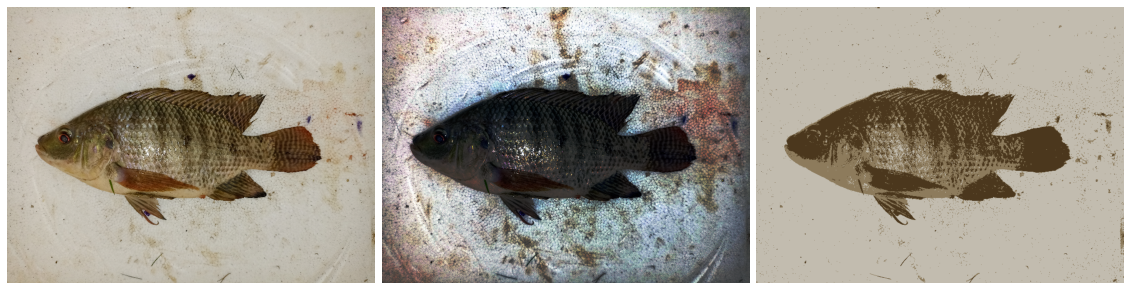

In [45]:
plot([image_rescaled, image_eq, results_kmeans], (1, 3))

In [110]:
results_kmeans_ch = results_kmeans[:, :, 0]

layers = [results_kmeans_ch == layer for layer in np.unique(results_kmeans_ch)]
layers_fixeds = list(map(auto_invert_image_mask, layers))

# layers_pixels_sum = list(map(lambda x: x.sum(), layers_fixeds))
layers_pixels_sum = list(map(lambda x: find_bighest_cluster_area(measure.label(x, background=0)), layers_fixeds))


best_layer = layers_fixeds[layers_pixels_sum.index(max(layers_pixels_sum))]

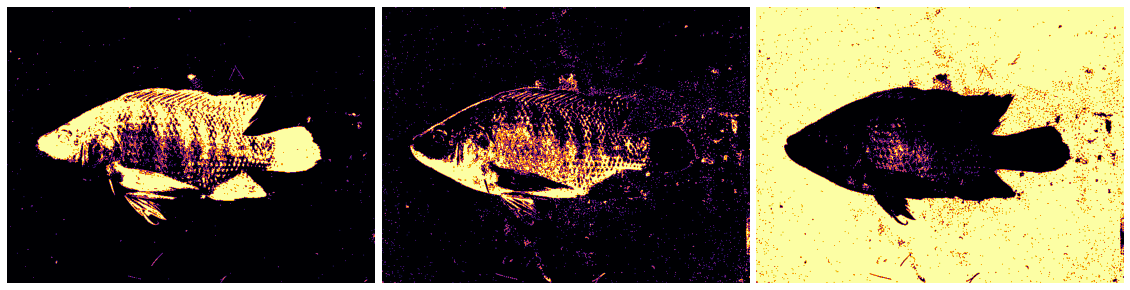

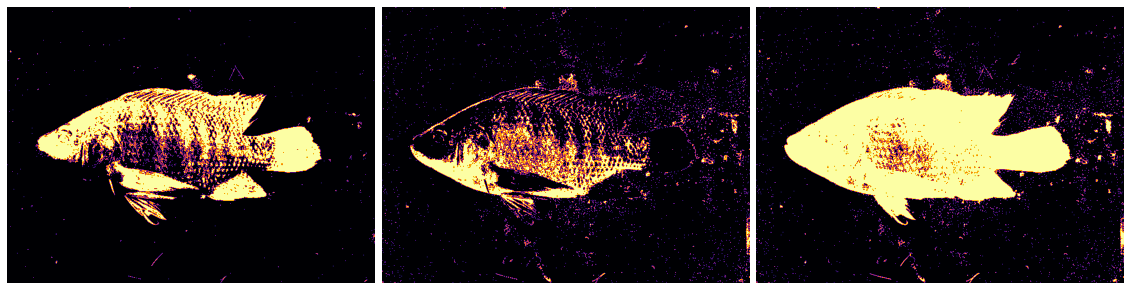

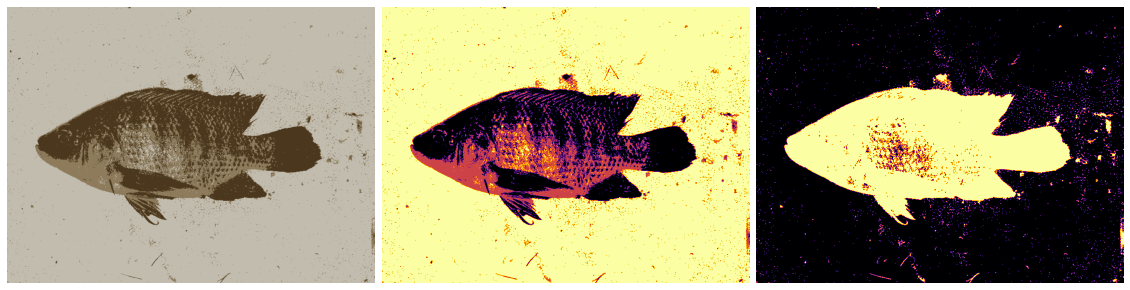

In [111]:
plot(layers, (1, 3))
plot(layers_fixeds, (1, 3))
plot([results_kmeans, results_kmeans_ch, best_layer], (1, 3))

In [112]:
def cleanup_mask(mask):
    
    mask = filters.gaussian(mask, sigma=0.2)
        
    mask = find_bighest_cluster(mask)

    return ndi.binary_fill_holes(mask)

In [113]:
mask = cleanup_mask(best_layer)

mask_image = merge_image_mask(image_rescaled, mask)

result_image = merge_image_mask(image_rescaled, best_layer)

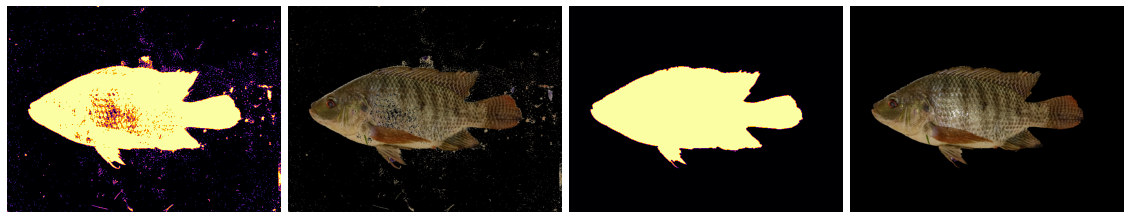

In [114]:
plot([best_layer, result_image, mask, mask_image], (1, 4))